<h1> <center>Generating Facies Trends with Seismic and Well data</center> </h1> 

**By**:  David Zhen Yin  
    
**Contact**: [yinzhen@stanford.edu](mailto:yinzhen@stanford.edu) 

**Date**:    Aug 4, 2020

This is the Python package to generate spatial trends of facies proportions. 

The package uses (input) Monte Carlo samples of facies proportions and forward modeled seismic reponse to learn their statistical relathionships. Then with real observed seismic responses, the statistical relationships will produce multiple realizations of facies trends.

The code is demontrated by the data example from Genesis field.

<img src = "src/workflow.jpg" title="Seismic2FaciesTrends" style="width: 500px;"/>
<center>Figure.  General concept of this package</center>  

# Settings

***Prerequisites***
To enable the Package, users need to have Python-3 and the following Python-3 modules installed:

* matplotlib
* numpy
* scipy
* statsmodels
* time
* warnings
* os
* sys

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Input data

Load Monte Carlo samples of prior faices proportions from 1D well modeling: ***fac_prop_pri***

***fac_prop_pri***: 2D array, [n_MCsamples, n_facies]

    'n_MCsamples': total number of Monte Carlos samples
    'n_facies': total number of facies. 
    In this example, 'n_facies=4'. They are: 0 - Massive Sand, 1 - Background Shale, 2-Thinbed, 3 - Margin silt

In [3]:
fac_prop_pri = np.load('data/input/facies_prop_mc.npy')

Load samples of forwarded seismic responses corresponding to the prior facies proportions: ***seis_pri***

***seis_pri***: 1D array, [n_MCsamples]

In [4]:
seis_pri = np.load('data/input/seis_amp_mc.npy')

Load real observed seismic map: ***SeisObs_map***
 
***SeisObs_map***: 2D array, [n_xdim, n_ydim]
    
    n_xdim, n_ydim are dimensions of the seismic map in x and y direction. It will be the dimension of final generated trend maps. 

In [5]:
SeisObs_map = np.load('data/input/seis_obs_map.npy')

**Visualize the input data**

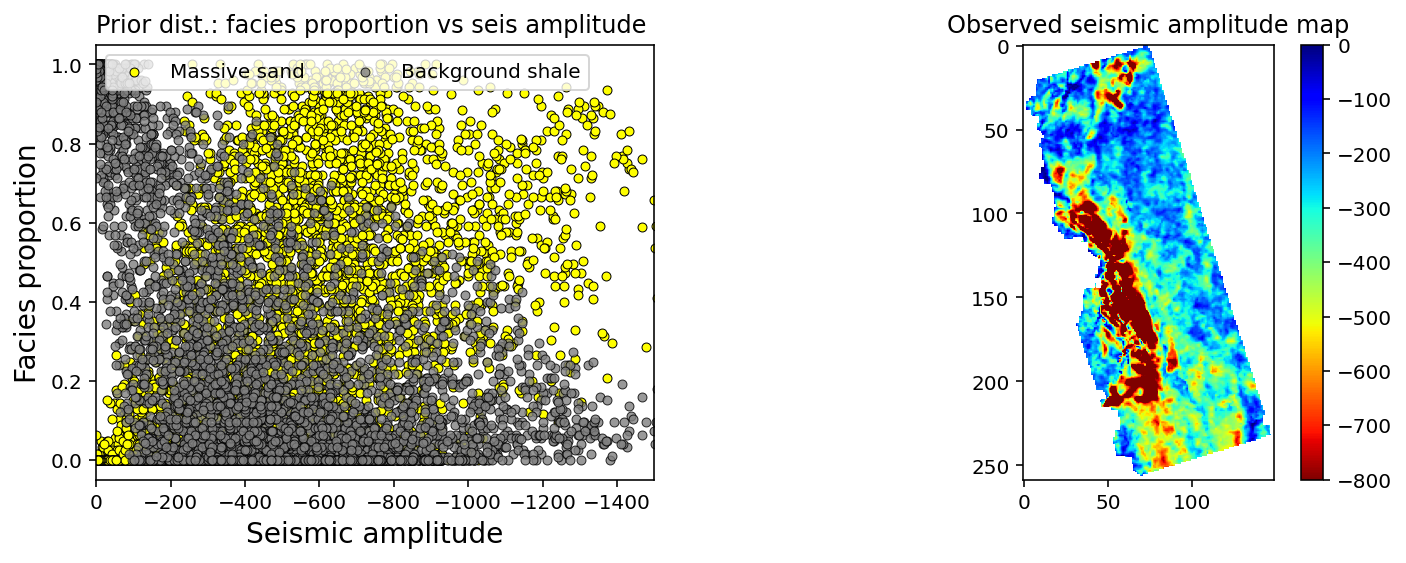

In [6]:
from src.viz_Genesis_input import viz_Genesis_input
viz_Genesis_input(fac_prop_pri, seis_pri, SeisObs_map) 

**Joint distribution of seismic amplitudes and the prior Monte Carlo lithofacies proportion samples**

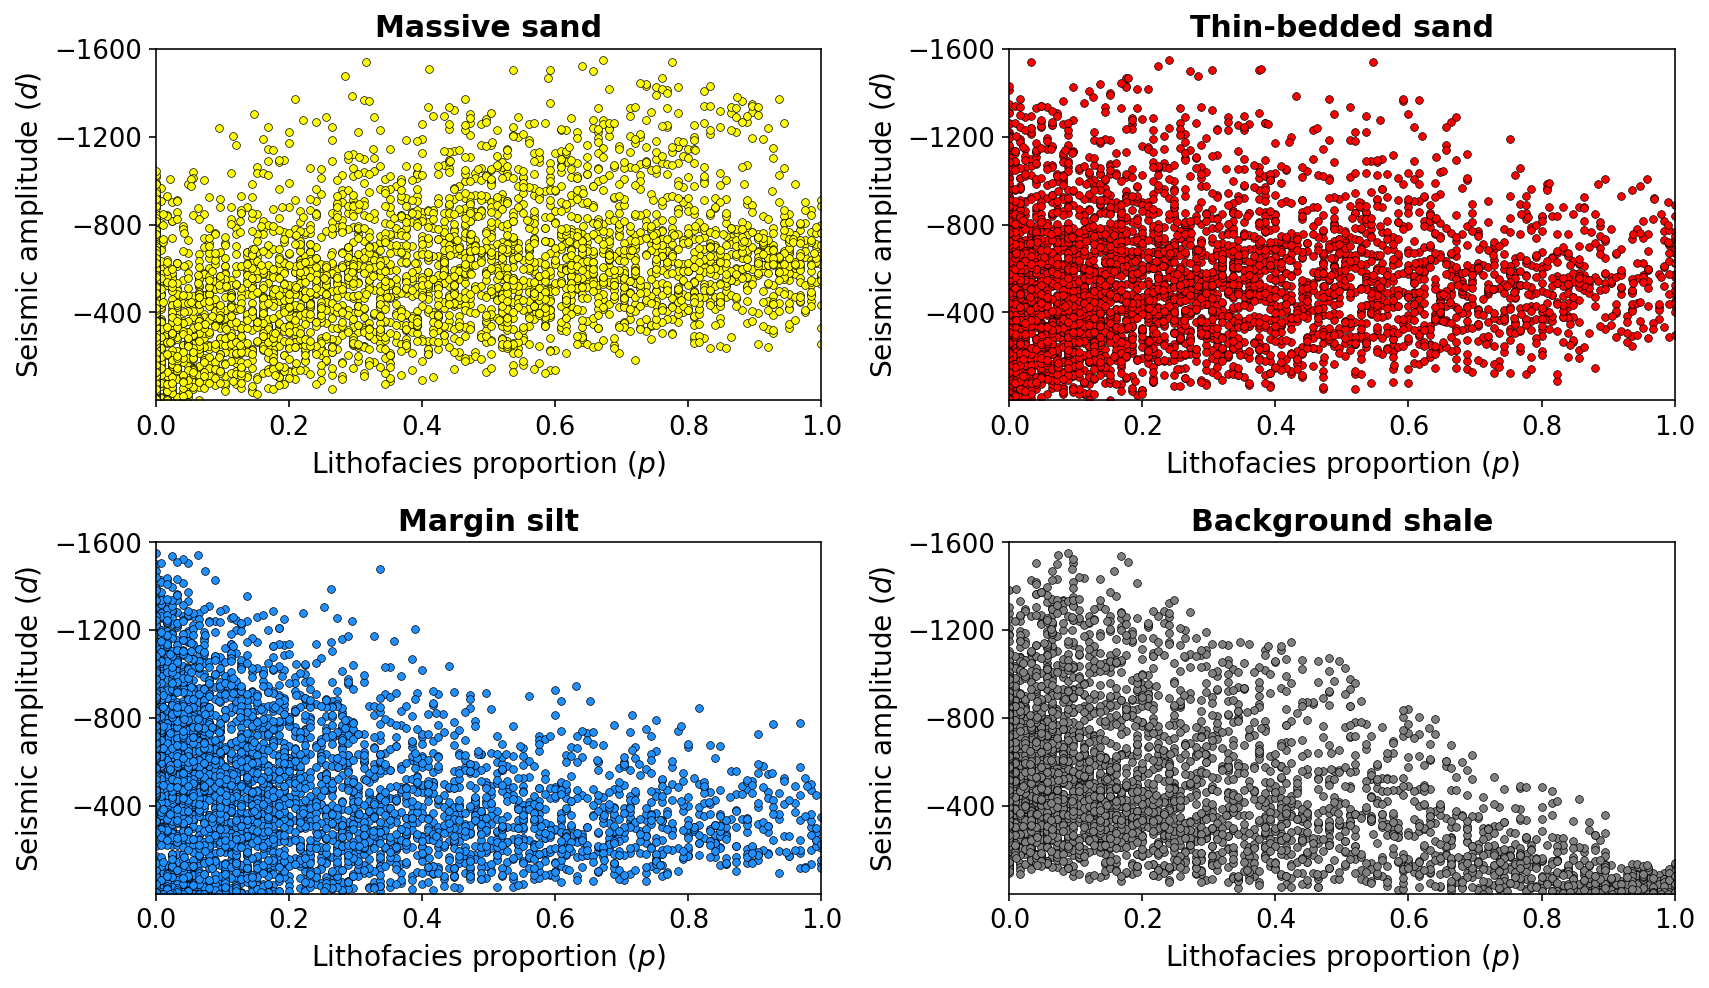

In [7]:
plt.figure(figsize=(12,7))
color=['yellow', 'grey', 'red', 'dodgerblue']
facies = [0, 2, 3, 1]
facies_name = ['Massive sand', 'Background shale', 'Thin-bedded sand', 'Margin silt']
subplt = 1
for i in facies:
    plt.subplot(2,2,subplt)
    plt.scatter(fac_prop_pri[:,i],seis_pri,  c = color[i], linewidths=0.35, edgecolors= 'k', s = 15)
    # sns.kdeplot(seis_pri, fac_prop_pri[:,i],  shade=True, cbar=True, cmap='jet', vmax=0.008)
    plt.gca().invert_xaxis()
    plt.ylim(0, -1600), plt.xlim(0, 1)
    plt.ylabel('Seismic amplitude ($d$)', fontsize=14)
    plt.xlabel('Lithofacies proportion ($p$)', fontsize=14)
    plt.title(facies_name[i], fontsize=15, weight='bold')
    plt.yticks([-400, -800, -1200, -1600], fontsize=13), plt.xticks(fontsize=13)
    subplt +=1
plt.tight_layout()

# Metropolis-Hastings 

Run Metropolis-Hastings under Dirichlet to sample posterior facies proportions

##  step 1. Estimate the Dirichlet distribution of prior facies proportions (via maximum likelihood estimation).

In [9]:
from src.direchlet_mle import direchlet_mle
alpha_pri = direchlet_mle(fac_prop_pri, tol=1e-4, maxiter=100000)
print('The lithofacies proportion follows Dirichlet distribution. Alpha of prior Dirichlet distribution is:')
print(alpha_pri)

The lithofacies proportion follows Dirichlet distribution. Alpha of prior Dirichlet distribution is:
[1.27334531 0.7083811  0.96083574 0.75918255]


## step 2. Discretize seismic observations to save runing time

In [24]:
seisobs_max, seisobs_min = -2090, 0
discre_stp = 20
seis_obs_dis = np.arange(seisobs_max, seisobs_min, discre_stp)

## Step 3. Run Metropolis-Hastings

In [45]:
from src.run_MH import run_MH
post_smpls_all = run_MH(fac_prop_pri, seis_pri, alpha_pri, seis_obs_dis, Maxstep=2000, 
                        delta_left=0.4, delta_right=7.13)

**QC Metropolis-Hastings results**

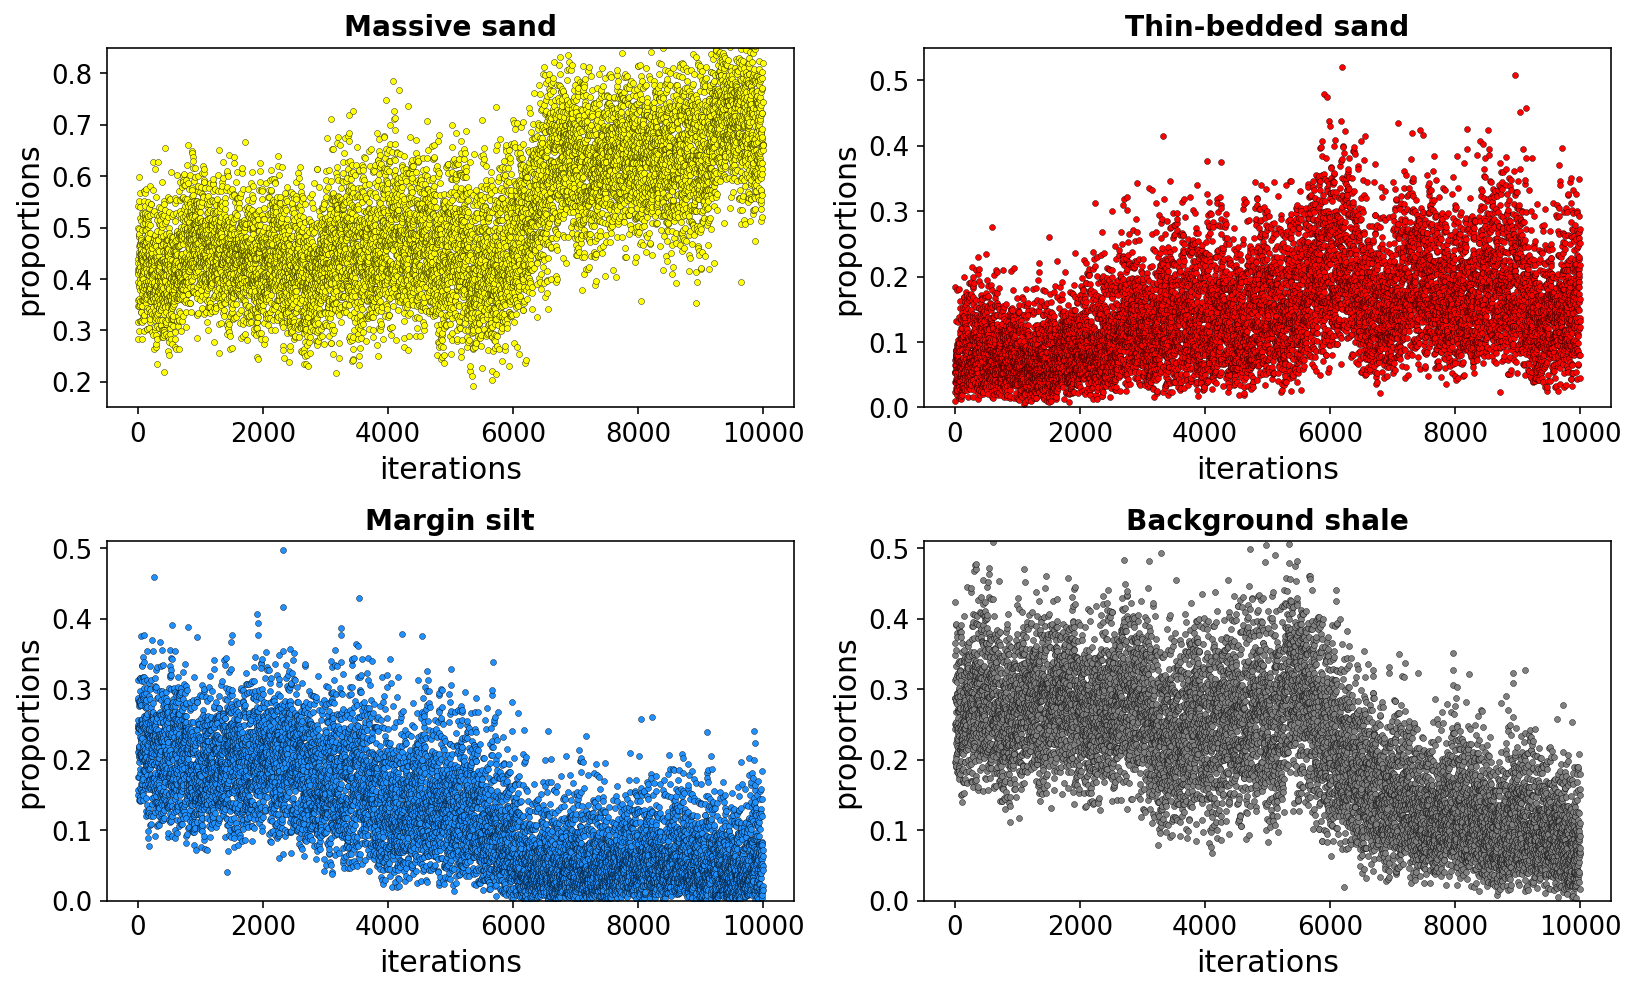

In [30]:
from src.check_Genesis_MH_results import check_Genesis_MH_results
# randomly provide a observed seismic responses
seis_obs = -1240
check_Genesis_MH_results(seis_obs, post_smpls_all, seis_obs_dis)

## step 4. Save posterior facies proportions samples

In [11]:
# save the last 2500 posterior samples
save_stp = 3000
post_prop_save = []
for i in range(len(post_smpls_all)):
    post_prop_save.append(post_smpls_all[i][-save_stp:,:])
post_prop_save = np.asarray(post_prop_save)
np.save('data/output/post_prop_smpls', post_prop_save)

# P-field simulation of faices trend

Define total realization number of facies trends to generate

In [21]:
n_trend_reals = 200 # int

In [22]:
# Load P-field maps, generated by SGSim
Pfields_smpls = np.load('data/input/P_fields_smpls.npy')
# Pfields_smpls:[n_samples, n_xdim, n_ydim]

# Load the previous saved posterior facies proporstions from MH. 
post_prptn_smpl = np.load('data/output/post_prop_smpls.npy')

**NB:** The P-field maps are generated using the opensource SGSim code from Prof. Michael J. Pyrcz (link: https://github.com/GeostatsGuy/GeostatsPy). If you need the adapted version for Genesis field, please let me know. 

**Step 1. Calculate empirical CDF of posterior proportions for P-field simulation**

In [23]:
from src.cal_emp_cdf import cal_emp_cdf
prptn_smpl_cdf = cal_emp_cdf(post_prptn_smpl)
Seis_prptn_cdf = [seis_obs_dis, prptn_smpl_cdf]

**Step 2. Perform P-field simulation to generate facies trends.** 

In [46]:
facies_trends.shape

(200, 259, 149, 4)

In [15]:
# Step 2. Perform P-field simulation to generate facies trends. 
from src.gen_trends_Psim import gen_trends_Psim
facies_trends = gen_trends_Psim(SeisObs_map, Pfields_smpls, Seis_prptn_cdf, n_trend_reals)

Estimated Running Time:18.49 minutes


**Save generated facies proportion trend maps**

In [48]:
fac_name = ['MSand', 'Bkgrnd', 'TSand','CMargin']
for i in range(len(fac_name)):
    np.save('./data/output/facies_trends_'+fac_name[i], facies_trends[:,:,:,i])

# Visualize poseterior facies proportion maps

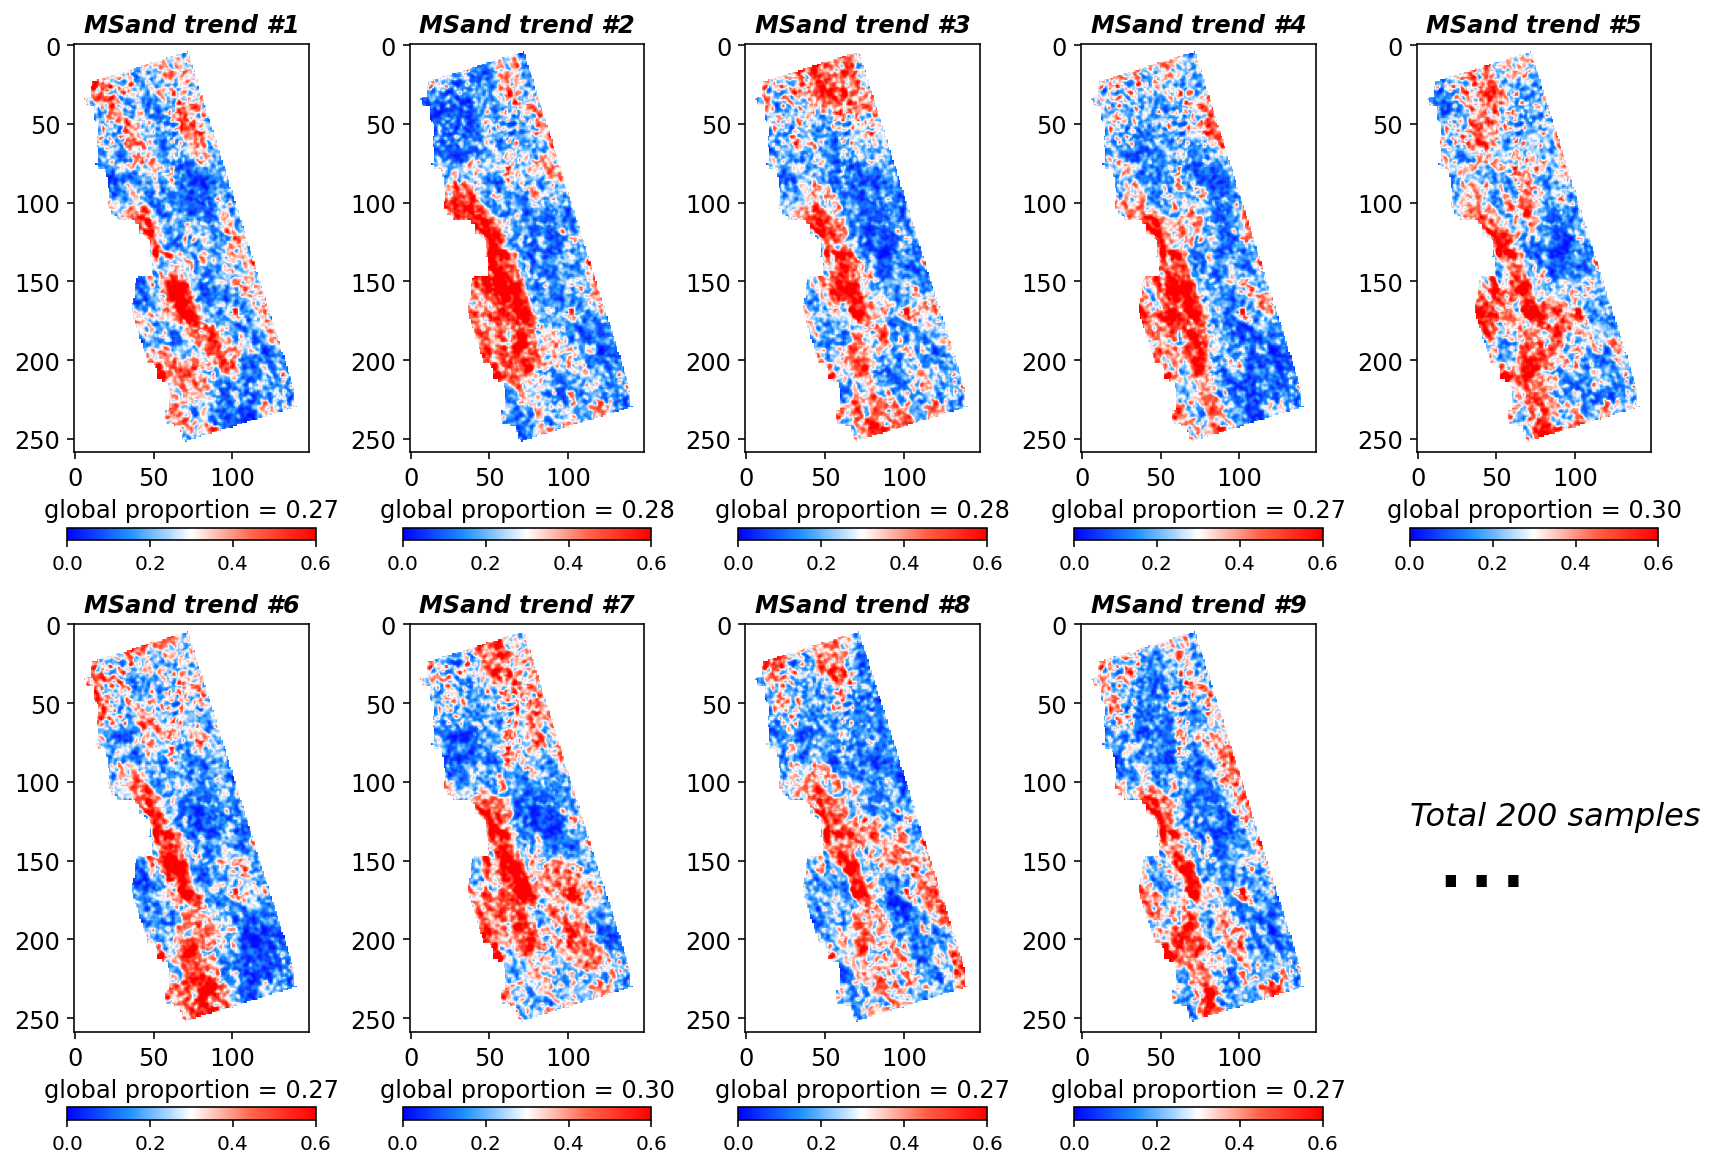

In [50]:
from src.trend_samples_vis import trend_samples_vis
fac_name = ['MSand', 'Bkgrnd', 'TSand','CMargin']
# provide which facies proportion map to plot, use plt_fac_id, int. 
# plt_fac_id: 0-MSand (massive sand), 1-Bkgrnd (background shale), 2-TSand (Thinbed sand), 3-CMargin (channel margin)
plt_fac_id = 0
# load selected facies proportion trend map
plt_facies_trends = np.load('./data/output/facies_trends_'+fac_name[plt_fac_id]+'.npy')
# Plot
trend_samples_vis(plt_facies_trends, fac_name[fac_])